In [4]:
.fix = \(f) f(.fix(f))

.pcase = .fix(\(self) \(val, pat, bind) {
    if(is.symbol(val) && is.symbol(pat)) {
        return(val == pat)
    }
    if(pat[[1]] == '.' && is.symbol(pat[[2]]) && length(pat) == 2) {
        bind(pat[[2]], val)
        return(TRUE)
    }
    if(is.call(val) && is.call(pat)) {
        for(i in 1:(length(pat)-1)) {
            if(!self(val[[i]], pat[[i]], bind)) {
                return(FALSE)
            }
        }
        p = pat[[i+1]]
        if(is.call(p) && p[[1]] == '..' && is.symbol(p[[2]]) && length(p) == 2) {jk
            if(length(val) < i+1) {
                bind(p[[2]], list())
            } else {
                bind(p[[2]], as.list(val[(i+1):length(val)]))
            }            
            return(TRUE)
        } else {
            return(self(el(val, i+1), el(pat, i+1), bind))
        }
        return(TRUE)
    }
    return(FALSE)
})

pcase = \(val, ...) {
    normalize = \(x) {
        if(x[[1]] == '(' && x[[2]][[1]] == '=') {
            x[[2]]
        } else {
            x
        }
    }
    for(case in list(...)) {
        acc = list()
        if(.pcase(val, normalize(case[[2]]), \(k,v) acc[deparse(k)] <<- list(v))) {
            return(eval.parent(bquote(with(.(acc), .(case[[3]])))))
        }        
    }
}

In [5]:
make.model = \(spec) {
    defs = pcase(spec, { ..(defs) } ~ defs)
    body = list()
    du = list()
    push.expr = \(e) body[length(body)+1] <<- list(e)
    push.state = \(s,n) {
        s = deparse(s)
        du[[s]][length(du[[s]])+1] <<- list(n)
    }
    for(def in defs) {
        pcase(def, 
              (.(lhs) = ..(rhs)) ~ {
                  push.expr(bquote(.(lhs) <- ..(rhs), splice=TRUE))
              },
              move(.(from), .(to), .(count)) ~ {
                  push.state(from, bquote(-.(count)))
                  push.state(to, count)
              },
              add(.(to), .(count)) ~ {
                  push.state(to, count)
              }
        )
    }
    for(s in names(du)) {
        rhs = Reduce(\(y,x) bquote(.(y)+.(x)), du[[s]])
        push.expr(bquote(du[.(s)] <- .(rhs)))
    }
    eval(bquote(\(t,u,p) {
        du = list()
        with(as.list(c(u,p)), { ..(body) })
        du[names(u)]
    }, splice=TRUE))
}

In [6]:
spec = quote({
    N = S+I+R+A
    J = (I+eta*A)/N    
    move(S,I, beta*J*S)
    move(I,R, gamma*I)
    move(R,S, mu*R)
    move(R,A, beta*J*R)
    move(A,R, gamma*A)
    add(S, b*N)
    move(S, Dn, d*S)
    move(I, Dn, d*I)
    move(R, Dn, d*R)
    move(A, Dn, d*A)
    move(I, Dd, delta*I)
    move(A, Dd, delta*kappa*A)
})

make.model(spec)

\(t,u,p) {
        du = list()
        with(as.list(c(u,p)), { ..(body) })
        du[names(u)]
    }
<environment: 0x55f1abb24430>

## DSL with no pattern matching

In [1139]:
make.model = \(spec) {    
    state = list()
    body = list()
    push.state = \(k,v) state[[k]][[length(state[[k]])+1]] <<- v
    push.body = \(v) body[[length(body)+1]] <<- v
    
    env = list(
        move = \(from,to,count) {            
            push.state(substitute(from), bquote(- .(substitute(count))))
            push.state(substitute(to), substitute(count))
        },
        '<-' = \(lhs, rhs) {
            push.body(bquote(.(substitute(lhs)) <- .(substitute(rhs))))
        },
        add = \(to, count) {            
            push.state(substitute(to), substitute(count))
        }
    )
    env['='] = env['<-']
    
    do.call(with, list(env, spec[[3]]))
    
    for(k in names(state)) {
        rhs = Reduce(\(acc,x) bquote(.(acc) + .(x)), state[[k]])
        push.body(bquote(du[.(as.symbol(k))] <- .(rhs)))
    }

    eval.parent(call('function', spec[[2]], bquote(splice=TRUE, {
        du = c()
        ..(body)
        list(du[names(u)])
    })))
}

In [1140]:
spec = quote(\(t,u,p) {
    # alias
    N = u[S]+u[I]+u[R]+u[A]
    J <- (u[I]+p$eta*u[A])/N
    bJ = p$beta %*% J
    
    # main structure
    move(S, I, bJ*u[S])
    move(I, R, p$gamma*u[I])
    move(R, S, p$mu*u[R])
    move(R, A, bJ*u[R])
    move(A, R, p$gamma*u[A])
    
    # natural birth and death
    add(S, p$b*N)
    move(S, Dn, p$d*u[S])
    move(I, Dn, p$d*u[I])
    move(R, Dn, p$d*u[R])
    move(A, Dn, p$d*u[A])
    
    # death from infection
    move(I, Dd, p$delta*u[I])
    move(A, Dd, p$delta*p$kappa*u[A])
})
model = make.model(spec)
model

function (t, u, p) 
{
    du = c()
    N <- u[S] + u[I] + u[R] + u[A]
    J <- (u[I] + p$eta * u[A])/N
    bJ <- p$beta %*% J
    du[S] <- -(bJ * u[S]) + p$mu * u[R] + p$b * N + -(p$d * u[S])
    du[I] <- bJ * u[S] + -(p$gamma * u[I]) + -(p$d * u[I]) + 
        -(p$delta * u[I])
    du[R] <- p$gamma * u[I] + -(p$mu * u[R]) + -(bJ * u[R]) + 
        p$gamma * u[A] + -(p$d * u[R])
    du[A] <- bJ * u[R] + -(p$gamma * u[A]) + -(p$d * u[A]) + 
        -(p$delta * p$kappa * u[A])
    du[Dn] <- p$d * u[S] + p$d * u[I] + p$d * u[R] + p$d * u[A]
    du[Dd] <- p$delta * u[I] + p$delta * p$kappa * u[A]
    list(du[names(u)])
}

In [835]:
par = list(
    eta = .5,
    beta=2.5/5,
    gamma=1/5,
    mu=1/100,
    b=7/1000/365,
    d=10/1000/365,
    delta=.5/100,
    kappa=1/20
)

times = seq(0, 365*30,by=1)

In [1157]:
Sm = paste('S', age.lowers, 'male')
Sf = paste('S', age.lowers, 'female')
Im = paste('I', age.lowers, 'male')
If = paste('I', age.lowers, 'female')
Rm = paste('R', age.lowers, 'male')
Rf = paste('R', age.lowers, 'female')
Am = paste('A', age.lowers, 'male')
Af = paste('A', age.lowers, 'female')

In [1160]:
sex.ratio = 94/100
u0 = c()
u0[Sm] = japan.population * sex.ratio/(sex.ratio+1)
u0[Sf] = japan.population * 1/(sex.ratio+1)


In [1176]:
crossing(
    japan.population,
    data.frame(sex=c('male', 'female'), rate=c(sex.ratio,1)/(sex.ratio+1))
) %>%
    transmute(sex, age.lower, count = count * rate) %>%

sex,age.lower,count
<chr>,<dbl>,<dbl>
female,0,2340907
male,0,2200453
female,5,2636173
male,5,2478002
female,10,2771169
male,10,2604898
female,15,2941395
male,15,2764911
female,20,3257711


In [1173]:
crossing(japan.population, data.frame(male=sex.ratio, female=1)/(sex.ratio+1))

age.lower,count,male,female
<dbl>,<dbl>,<dbl>,<dbl>
0,4541360,0.4845361,0.5154639
5,5114175,0.4845361,0.5154639
10,5376067,0.4845361,0.5154639
15,5706306,0.4845361,0.5154639
20,6319959,0.4845361,0.5154639
25,6384151,0.4845361,0.5154639
30,6713773,0.4845361,0.5154639
35,7498375,0.4845361,0.5154639
40,8476244,0.4845361,0.5154639


In [1168]:
japan.population$count * c(sex.ratio,1)/(sex.ratio+1)

[1] 2200453 2636173 2604898 2941395 3062248 3290799 3253065 3865142 4107046
[10] 5086832 4233915 4092852 3606107 4245502 4452184 9588561

In [866]:
ages = c(0,20,40,60)
S = paste('S', ages)
I = paste('I', ages)
R = paste('R', ages)
A = paste('A', ages)
Dn = paste('Dn', ages)
Dd = paste('Dd', ages)

# https://www.mhlw.go.jp/english/database/db-hh/1-1.html
# https://www.mhlw.go.jp/english/database/db-hw/lifetb23nd/index.html
u0 = c()
u0[S] = c(
    4541+5114+5376+5706, # 0~19
    6320+6384+6714+7498, # 20~39
    8476+9868+8738+7940, # 40~59,
    7442+8236+9189+7065+5404+6133 # 60~
) * 1e3
u0[I] = c(
    100,
    100,
    100,
    100
)
u0[c(R,A)] = 0

timeit({
    sol = ode(u0, times, model, par)
    invisible()
})

Time difference of 1.557999 secs

In [ ]:
S = 'S'
I = 'I'
R = 'R'
A = 'A'
Dn = 'Dn'
Dd = 'Dd'

u0 = c()
u0[S] = 126e6
u0[I] = 100
u0[c(R,A)] = 0

t = timeit({
    sol = ode(u0, times, model, par)
    invisible()
})

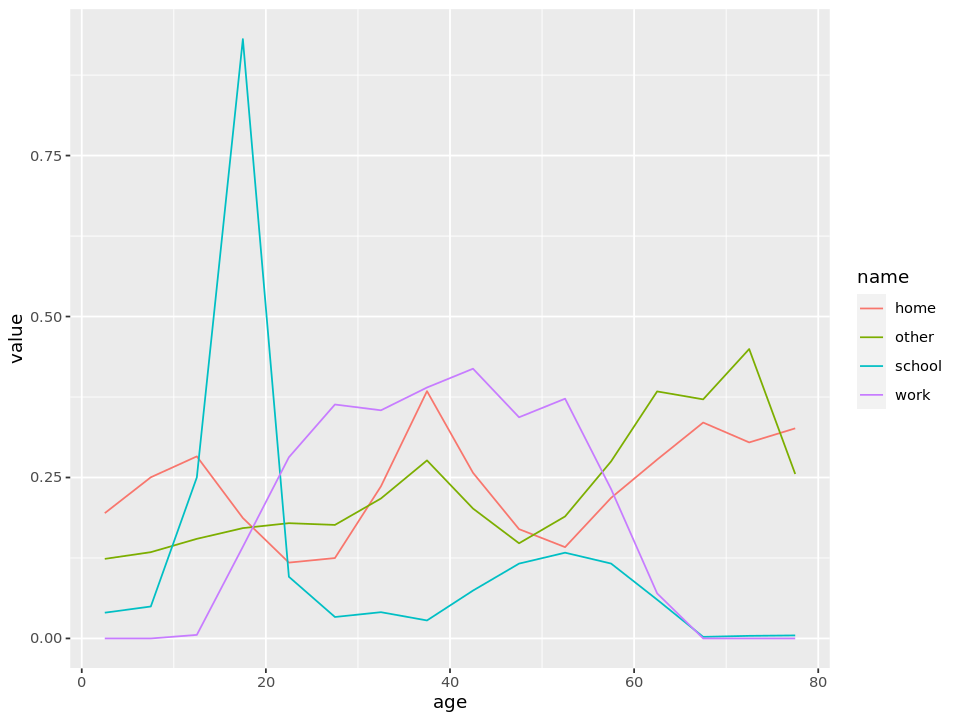

In [1155]:
figsize(8,6)
data.frame(
    age = age.lowers+5/2,
    home = abs(eigen(C.home)$vectors[,1]),
    school = abs(eigen(C.school)$vectors[,1]),
    work = abs(eigen(C.work)$vectors[,1]),
    other = abs(eigen(C.other)$vectors[,1])
) %>% 
    pivot_longer(-age) %>%
    ggplot() +
    geom_line(aes(age, value, col=name))

In [880]:
age.names = with(c(), {
    ages = seq(0,80,by=5)
    res = c()
    for(i in 1:(length(ages)-1)) {
        res[i] = paste0(ages[[i]], '-', ages[[i+1]])
    }
    res
})

In [1023]:
C.home = read_xlsx('contact_matrices_152_countries/MUestimates_home_1.xlsx', sheet='Japan')
C.school = read_xlsx('contact_matrices_152_countries/MUestimates_school_1.xlsx', sheet='Japan')
C.work = read_xlsx('contact_matrices_152_countries/MUestimates_work_1.xlsx', sheet='Japan')
C.other = read_xlsx('contact_matrices_152_countries/MUestimates_other_locations_1.xlsx', sheet='Japan')

In [1024]:
for(v in ls()[startsWith(ls(), 'C.')]) {
    v = as.symbol(v)
    eval(bquote(colnames(.(v)) <- age.names))
}

In [933]:
figsize = \(width,height) 
    options(repr.plot.width=width, repr.plot.height=height)

In [1137]:
age.lowers = seq(0,by=5,length.out = 16)
age.lowers

[1]  0  5 10 15 20 25 30 35 40 45 50 55 60 65 70 75

In [1199]:
japan.population = read_xlsx('japan-total-population.xlsx') %>%
    drop_na() %>%
    .[2:19,2:4] %>%
    set_names(c('total', 'male', 'female')) %>% {
        .[1:length(age.lowers),'age.lower'] = age.lowers
        fill(., age.lower)
    } %>%
    mutate(across(-age.lower, ~ as.numeric(.)*1e3)) %>%
    group_by(age.lower) %>%
    summarise(
        age.lower=first(age.lower),
        across(c(total,male,female), ~ sum(.))
    )
japan.population

New names:
• `` -> `...2`
• `` -> `...3`
• `` -> `...4`
• `` -> `...5`
• `` -> `...6`
• `` -> `...7`
• `` -> `...8`
• `` -> `...9`


age.lower,total,male,female
<dbl>,<dbl>,<dbl>,<dbl>
0,4541360,2324576,2216784
5,5114175,2619882,2494293
10,5376067,2755578,2620489
15,5706306,2927618,2778688
20,6319959,3233994,3085965
25,6384151,3279149,3105002
30,6713773,3431250,3282523
35,7498375,3805952,3692423
40,8476244,4298675,4177569


In [728]:
timeit({
sol = ode(
    u0,
    seq(0,365*20,by=1),
    model,
    par
)
})

Time difference of 1.080338 secs


time,S 0,S 20,S 40,S 60,I 0,I 20,I 40,I 60,R 0,R 20,R 40,R 60,A 0,A 20,A 40,A 60
0,20737000,26916000,35022000,43469000,100.0000,100.0000,100.0000,100.0000,0.00000,0.00000,0.00000,0.00000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
1,20736772,26915721,35021654,43468585,134.3086,134.3086,134.3087,134.3088,23.15186,23.15188,23.15189,23.15190,3.058885e-05,2.356673e-05,1.811213e-05,1.459256e-05
2,20736523,26915422,35021289,43468150,180.3876,180.3879,180.3882,180.3883,54.01569,54.01577,54.01583,54.01587,1.592024e-04,1.226553e-04,9.426642e-05,7.594847e-05
3,20736249,26915096,35020897,43467688,242.2751,242.2759,242.2765,242.2769,95.23952,95.23978,95.23998,95.24011,4.773587e-04,3.677752e-04,2.826530e-04,2.277278e-04
4,20735939,26914736,35020469,43467191,325.3944,325.3961,325.3974,325.3983,150.37978,150.38043,150.38093,150.38126,1.156426e-03,8.909566e-04,6.847446e-04,5.516855e-04
5,20735581,26914327,35019994,43466647,437.0283,437.0319,437.0347,437.0364,224.21262,224.21408,224.21522,224.21595,2.513445e-03,1.936465e-03,1.488274e-03,1.199075e-03
6,20735159,26913854,35019455,43466038,586.9583,586.9654,586.9709,586.9744,323.15266,323.15573,323.15811,323.15965,5.130694e-03,3.952922e-03,3.038037e-03,2.447697e-03
7,20734651,26913296,35018829,43465343,788.3194,788.3331,788.3438,788.3506,455.81418,455.82035,455.82514,455.82823,1.007174e-02,7.759781e-03,5.963846e-03,4.804990e-03
8,20734028,26912621,35018088,43464533,1058.7507,1058.7767,1058.7969,1058.8100,633.76568,633.77771,633.78707,633.79310,1.927304e-02,1.484905e-02,1.141244e-02,9.194890e-03
9,20733249,26911792,35017192,43463568,1421.9372,1421.9860,1422.0238,1422.0483,872.54170,872.56471,872.58259,872.59412,3.624987e-02,2.792931e-02,2.146564e-02,1.729475e-02


In [707]:
S = 'susceptible'
I = 'infective'
R = 'recovered'
A = 'asymptomatic'
Dn = 'death'
Dd = 'death from infection'

u0 = c()
u0[c(S,I,R,A,Dn,Dd)] = c(126e6, 100, 0, 0, 0, 0)
ts = seq(0, 365*20, by=1)

In [841]:
timeit = \(expr) {
    t = Sys.time()
    eval.parent(substitute(expr))
    Sys.time() - t
}

In [678]:
timeit({
    sol = data.frame()
    u = u0
    for(t in ts) {
        du = model(t, u, par)[[1]]        
        nsol = nrow(sol)        
        for(k in names(u0)) {
            u[[k]] = u[[k]] + du[[k]]
        }
        sol[nsol+1, 'time'] = t
        sol[nsol+1, names(u0)] = u
    }
})

Time difference of 3.90444 secs


NULL

In [687]:
timeit({
    sol = data.frame()
    u = u0
    tp = ts[[1]]
    sol[1, 'time'] = tp
    sol[1, names(u0)] = u
    for(t in tail(ts, -1)) {
        du = model(t, u, par)[[1]]
        dt = t - tp
        nsol = nrow(sol)
        u = u + du*dt
        tp = t
        sol[nsol+1, 'time'] = t
        sol[nsol+1, names(u0)] = u
    }
    sol
})

Time difference of 3.8986 secs


,time,susceptible,infective,recovered,asymptomatic,death,death from infection
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0,126000000,100.0000,0.00000,0.000000e+00,0.000,0.000000
2,1,125998914,129.4972,20.00000,0.000000e+00,3452.058,0.500000
3,2,125997814,167.6953,45.69889,1.027763e-05,6904.087,1.147486
4,3,125996695,217.1606,78.77967,3.863040e-05,10356.087,1.985962
5,4,125995552,281.2168,121.42179,9.878350e-05,13808.060,3.071766
6,5,125994377,364.1677,176.44750,2.145032e-04,17260.004,4.477850
7,6,125993161,471.5864,247.51151,4.265394e-04,20711.919,6.298688
8,7,125991892,610.6903,339.34653,8.043227e-04,24163.806,8.656621
9,8,125990555,790.8251,458.08116,1.465646e-03,27615.665,11.710072


Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Removed 2 rows containing missing values (`geom_line()`).”


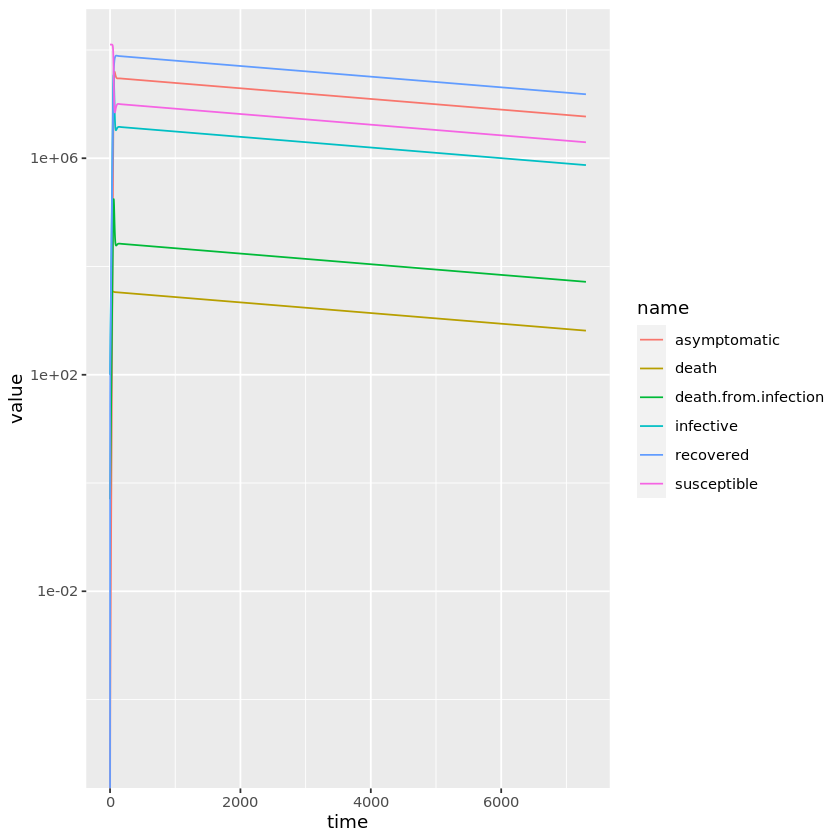

In [691]:
data.frame(sol) %>%
    mutate(across(starts_with('death'), ~ . - lag(.))) %>%
    pivot_longer(-time) %>%
    ggplot() +
    geom_line(aes(time, value, col=name)) +
    scale_y_log10()

Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Removed 2 rows containing missing values (`geom_line()`).”


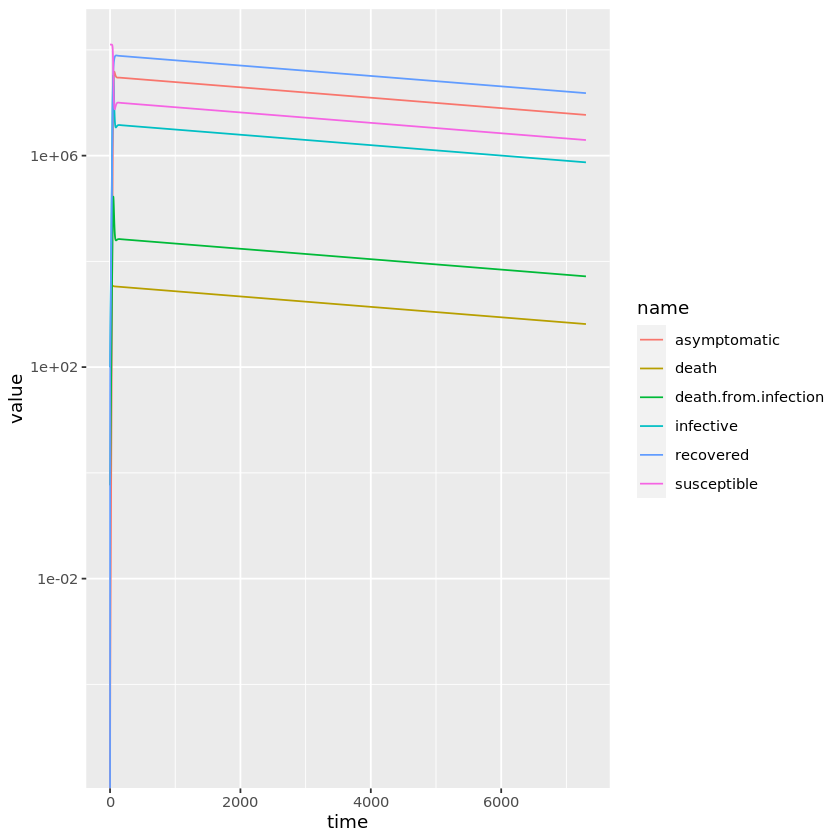

In [633]:
sol = ode(u0, ts, make.model(spec), par)

data.frame(sol) %>%
    mutate(across(starts_with('death'), ~ . - lag(.))) %>%
    pivot_longer(-time) %>%
    ggplot() +
    geom_line(aes(time, value, col=name)) +
    scale_y_log10()

In [198]:
spec = quote({
    N = S+I+R+A
    J <- (I+eta*A)/N
    move(S, I, beta(t)*J*S)
    move(I, R, gamma*I)
    move(R, S, mu*R)
    move(R, A, beta(t)*J*R)
    move(A, R, gamma*A)
    
    add(S, b*N)
    move(S, Dn, d*S)
    move(I, Dn, d*I)
    move(R, Dn, d*R)
    move(A, Dn, d*A)
    
    move(I, Dd, delta*I)
    move(A, Dd, delta*kappa*A)    
})
make.model(spec)

\(t,u,p) {
        du = c()
        with(as.list(c(u,p)), { ..(body) })
        list(du[names(u)])
    }
<environment: 0x55f1afc4ced0>

In [126]:
require(tidyverse)
require(deSolve)

Loading required package: tidyverse

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.0     ✔ purrr   1.0.1
✔ tibble  3.1.8     ✔ dplyr   1.1.0
✔ tidyr   1.3.0     ✔ stringr 1.5.0
✔ readr   2.1.3     ✔ forcats 1.0.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
Loading required package: deSolve



In [360]:
macro = \(f) \(...)
    eval.parent(do.call(f, as.list(tail(match.call(), -1)), quote = TRUE))

In [373]:
x = list()
n = 1
a = 'S'
b = 'I'
move(x,a,b,n)

ERROR: Error in x[a] - n: non-numeric argument to binary operator


In [420]:
add = macro(\(acc, to, amount) {
    bquote({
        if(.(to) %in% .(acc)[.(to)]) {
            .(acc)[.(to)] <- .(acc)[.(to)] + .(amount)
        } else {
            .(acc)[.(to)] <- .(amount)
        }
    })
})

move = macro(\(acc, from, to, amount) {
    bquote({
        add(.(acc), .(from), -.(amount))
        add(.(acc), .(to), +.(amount))
    })
})

In [428]:
# ages = c(0,20,40,60)
# S = paste('S', ages)
# I = paste('I', ages)
# R = paste('R', ages)
# A = paste('A', ages)
S = 'S'
I = 'I'
R = 'R'
A = 'A'
Dn = 'Dn'
Dd = 'Dd'

model = \(t,u,p) {
    du = c()
        N = u[S] + u[I] + u[R] + u[A]
        J = u[I] + eta*u[A]
        betaJ = beta * J
        move(du, S, I, betaJ*u[S])
        move(du, I, R, gamma*u[I])
        move(du, R, S, mu*u[R])
        move(du, R, A, betaJ*u[R])
        move(du, A, R, gamma*u[A])
        
        add(du, S, b*N)
        move(du, S, Dn, d*u[S])
        move(du, I, Dn, d*u[I])
        move(du, R, Dn, d*u[R])
        move(du, A, Dn, d*u[A])
        
        move(du, I, Dd, delta*u[I])
        move(du, A, Dd, delta*kappa*u[A])
    
    list(du[names(u)])
}
model

\(t,u,p) {
    du = c()
        N = u[S] + u[I] + u[R] + u[A]
        J = u[I] + eta*u[A]
        betaJ = beta * J
        move(du, S, I, betaJ*u[S])
        move(du, I, R, gamma*u[I])
        move(du, R, S, mu*u[R])
        move(du, R, A, betaJ*u[R])
        move(du, A, R, gamma*u[A])
        
        add(du, S, b*N)
        move(du, S, Dn, d*u[S])
        move(du, I, Dn, d*u[I])
        move(du, R, Dn, d*u[R])
        move(du, A, Dn, d*u[A])
        
        move(du, I, Dd, delta*u[I])
        move(du, A, Dd, delta*kappa*u[A])
    
    list(du[names(u)])
}

In [429]:
u0 = c(S=126e6, I=100, R=0, A=0)

eta = .5
beta = 2.5/5
gamma = 1/5
mu = 1/100
b = 1-(1-7.397/1000)^(1/365) # 7.397 births per 1000 people annualy
d = 1-(1-10.9/1000)^(1/365) # 10.9 deaths per 1,000 people annualy
delta = 0.5/100
kappa = 1/20

sol = ode(u0,
    seq(0,365*3,by=1),
    model,
    c()
)

In [430]:
sol

time,S,I,R,A
0,126000000,100.00000,0,0
1,125996217,99.50125,0,0
2,125992434,99.00498,0,0
3,125988650,98.51119,0,0
4,125984868,98.01986,0,0
5,125981085,97.53099,0,0
6,125977302,97.04455,0,0
7,125973519,96.56054,0,0
8,125969737,96.07894,0,0
9,125965955,95.59975,0,0


Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Removed 2 rows containing missing values (`geom_line()`).”


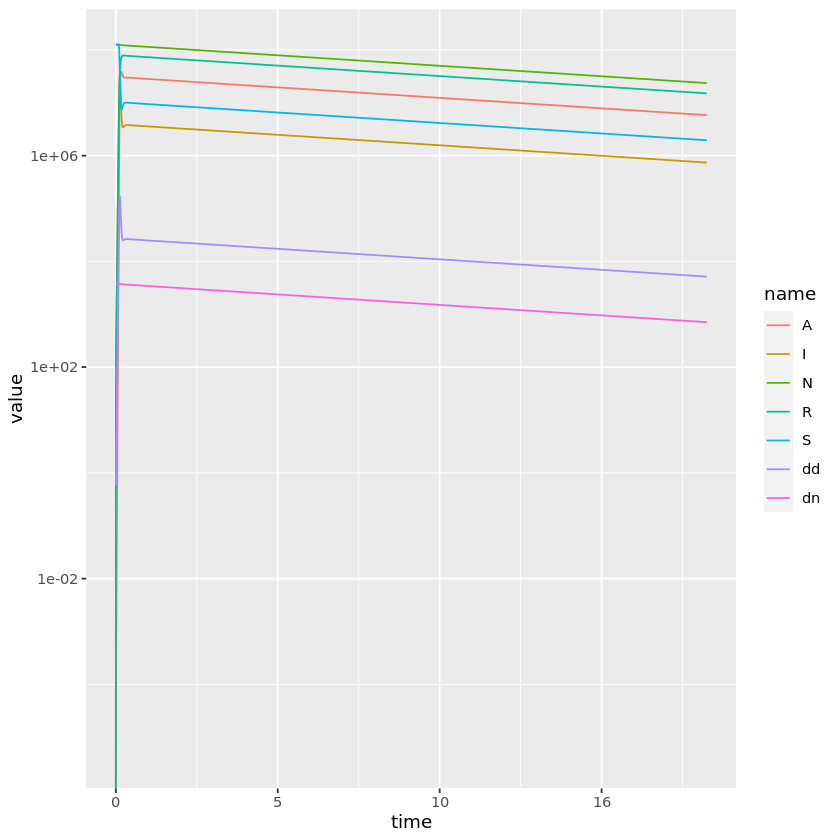

In [186]:
data.frame(sol) %>%
    mutate(
        N = S+I+R+A,
        dd = Dd-lag(Dd),
        dn = Dn-lag(Dn)
    ) %>%
    select(-c(Dd, Dn)) %>%
    pivot_longer(-time) %>%
    ggplot() +
    geom_line(aes(time, value, col=name)) +
    scale_y_log10() +
    scale_x_continuous(labels = ~floor(. /365))
    # scale_x_continuous(limits = c(NA, 365*3))